# Impactos da escolaridade no mercado de trabalho no Brasil

O objetivo dessa análise é elucidar o papel da escolaridade das famílias, seus impactos no mercado de trabalho e consequente na desigualdade de rendas no Brasil. As bases de dados utilizadas pertencem à PNAD Contínua (IBGE) e ao IDEB (INEP).


As hipóteses a serem verificadas são:
* A formalização do trabalho aumenta com o nível de instrução;
* As horas trabalhadas aumentam com o nível de escolaridade; 
* O rendimento mensal aumenta com o nível de formalidade.

## 1. Rendimento médio mensal e formalidade
### 1.1. Coleta e limpeza

In [39]:
import pandas as pd
import sidrapy
from google.cloud import bigquery
import basedosdados as bd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

billing_id = "ufrj-analytica-441600"

In [40]:
# Tabela 6389 - Rendimento médio mensal real das pessoas de 14 anos ou mais de idade ocupadas na semana de referência com rendimento de trabalho, habitualmente recebido no trabalho principal
tabela_rendimentos = sidrapy.get_table(table_code="6389",
    territorial_level="1",
    ibge_territorial_code="all",
    period="all",
    variable="5932", # Rendimento médio mensal real das pessoas habitualmente recebido no trabalho principal
    classifications={"11913": "31722,31725,31728,31730,45934,45936,31723,31726,31729,45935,45937"})
tabela_rendimentos.head()

,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N,D4C,D4N
0,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Brasil (Código),Brasil,Trimestre Móvel (Código),Trimestre Móvel,Variável (Código),Variável,Posição na ocupação e categoria do emprego no ...,Posição na ocupação e categoria do emprego no ...
1,1,Brasil,38,Reais,2768,1,Brasil,201203,jan-fev-mar 2012,5932,Rendimento médio mensal real das pessoas de 14...,31722,"Empregado no setor privado, exclusive trabalha..."
2,1,Brasil,38,Reais,1466,1,Brasil,201203,jan-fev-mar 2012,5932,Rendimento médio mensal real das pessoas de 14...,31725,Trabalhador doméstico - com carteira de trabal...
3,1,Brasil,38,Reais,4333,1,Brasil,201203,jan-fev-mar 2012,5932,Rendimento médio mensal real das pessoas de 14...,31728,"Empregado no setor público, exclusive militar ..."
4,1,Brasil,38,Reais,5004,1,Brasil,201203,jan-fev-mar 2012,5932,Rendimento médio mensal real das pessoas de 14...,31730,Empregado no setor público - militar e funcion...


In [41]:
def converter_trimestre(data_str):
    ano = int(data_str[:4])
    mes = int(data_str[4:6])
    return pd.Timestamp(f"{ano}-{mes:02d}") + pd.offsets.MonthEnd(0)

In [42]:
# Primeira coluna como cabeçalho
df_rendimentos = tabela_rendimentos
df_rendimentos.columns = df_rendimentos.iloc[0]
df_rendimentos = df_rendimentos[1:]

# Colunas de interesse
df_rendimentos = df_rendimentos.iloc[1:, [4, 7, 12]]
df_rendimentos['Valor'] = pd.to_numeric(df_rendimentos['Valor'], errors='coerce')
df_rendimentos["Trimestre Móvel (Código)"] = df_rendimentos["Trimestre Móvel (Código)"].apply(converter_trimestre)

# Renomeia as colunas
df_rendimentos.rename(columns={"Trimestre Móvel (Código)": "data",
                              "Posição na ocupação e categoria do emprego no trabalho principal": "categoria_emprego",
                              "Valor": "valores"}, 
                              inplace=True)
df_rendimentos = df_rendimentos.pivot(index="data", columns="categoria_emprego", values="valores")

# Converte a frequência do df
df_rendimentos = df_rendimentos.asfreq("Q")

df_rendimentos.head(10)

categoria_emprego,Conta própria com CNPJ,Conta própria sem CNPJ,"Empregado no setor privado, exclusive trabalhador doméstico - com carteira de trabalho assinada","Empregado no setor privado, exclusive trabalhador doméstico - sem carteira de trabalho assinada",Empregado no setor público - militar e funcionário público estatutário,"Empregado no setor público, exclusive militar e funcionário público estatutário - com carteira de trabalho assinada","Empregado no setor público, exclusive militar e funcionário público estatutário - sem carteira de trabalho assinada",Empregador com CNPJ,Empregador sem CNPJ,Trabalhador doméstico - com carteira de trabalho assinada,Trabalhador doméstico - sem carteira de trabalho assinada
data,,,,,,,,,,,
2012-03-31,NaN,NaN,NaN,1752.0,5004.0,4333.0,2329.0,NaN,NaN,1466.0,927.0
2012-06-30,NaN,NaN,2787.0,1704.0,5055.0,4345.0,2202.0,NaN,NaN,1520.0,899.0
2012-09-30,NaN,NaN,2770.0,1701.0,5041.0,4062.0,2211.0,NaN,NaN,1512.0,900.0
2012-12-31,NaN,NaN,2783.0,1655.0,5018.0,4385.0,2232.0,NaN,NaN,1505.0,923.0
2013-03-31,NaN,NaN,2811.0,1690.0,5045.0,4383.0,2465.0,NaN,NaN,1518.0,934.0
2013-06-30,NaN,NaN,2830.0,1747.0,5088.0,4518.0,2404.0,NaN,NaN,1549.0,946.0
2013-09-30,NaN,NaN,2856.0,1780.0,5178.0,4223.0,2280.0,NaN,NaN,1568.0,969.0
2013-12-31,NaN,NaN,2865.0,1746.0,5280.0,3930.0,2369.0,NaN,NaN,1582.0,988.0
2014-03-31,NaN,NaN,2899.0,1759.0,5261.0,4176.0,2555.0,NaN,NaN,1621.0,1013.0


In [43]:
df_rendimentos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2012-03-31 to 2024-09-30
Freq: Q-DEC
Data columns (total 11 columns):
 #   Column                                                                                                               Non-Null Count  Dtype  
---  ------                                                                                                               --------------  -----  
 0   Conta própria com CNPJ                                                                                               36 non-null     float64
 1   Conta própria sem CNPJ                                                                                               36 non-null     float64
 2   Empregado no setor privado, exclusive trabalhador doméstico - com carteira de trabalho assinada                      50 non-null     float64
 3   Empregado no setor privado, exclusive trabalhador doméstico - sem carteira de trabalho assinada                      51 non-null  

In [44]:
# Datas em que há dados faltantes
df_rendimentos[df_rendimentos.isna().any(axis=1)].index

DatetimeIndex(['2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30'],
              dtype='datetime64[ns]', name='data', freq='Q-DEC')

As séries pautadas sobre o CNPJ foram iniciadas a partir de 2015, o que justifica os dados faltantes.

### 1.2. Análise e Resultados
A formalização foi definida com base nos trabalhadores que possuem registro de carteira de trabalho ou CNPJ próprio. É possível verificar que a formalização contribui para rendimentos maiores em todos as classes de rendimentos. O ponto de destaque vai para os empreendedores, em que a formalização está associada com um nível de renda significativamente maior que em relação à informalidade. O primeiro gráfico mostra os níveis de renda por tipo de trabalho e o segundo gráfico mostra a mesma relação em termos agregados.

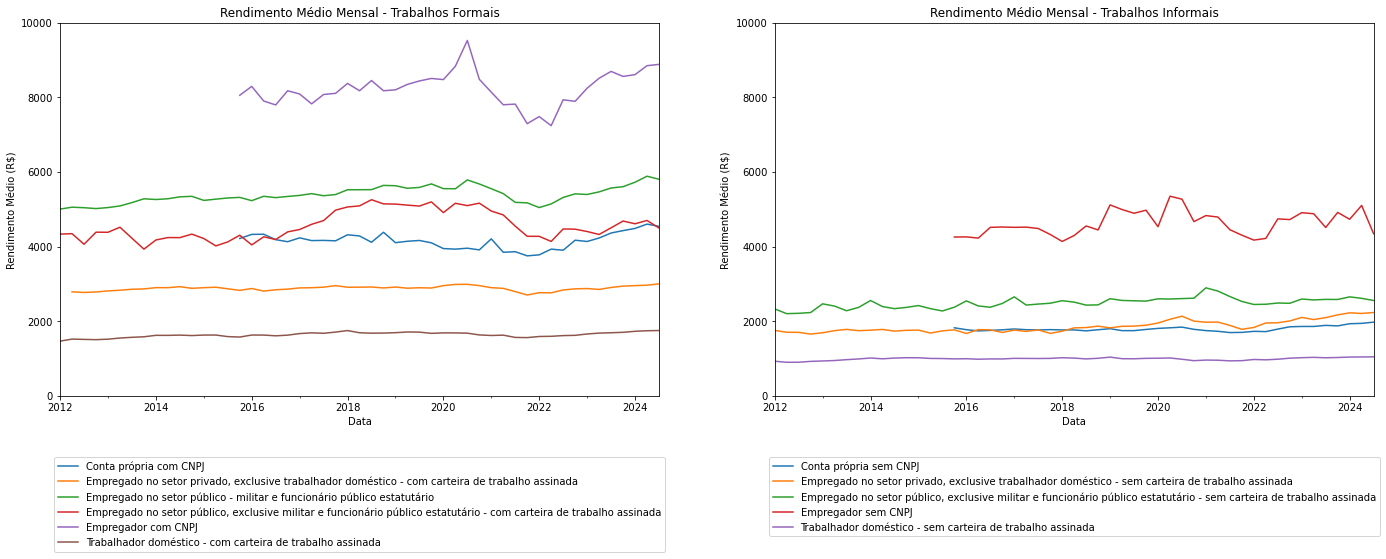

In [45]:
tipo_trabalho = {"trabalho_formal": ['Conta própria com CNPJ',
                                    'Empregado no setor privado, exclusive trabalhador doméstico - com carteira de trabalho assinada',
                                    'Empregado no setor público - militar e funcionário público estatutário',
                                    'Empregado no setor público, exclusive militar e funcionário público estatutário - com carteira de trabalho assinada',
                                    'Empregador com CNPJ',
                                    'Trabalhador doméstico - com carteira de trabalho assinada'],
                "trabalho_informal": ['Conta própria sem CNPJ',
                                    'Empregado no setor privado, exclusive trabalhador doméstico - sem carteira de trabalho assinada',
                                    'Empregado no setor público, exclusive militar e funcionário público estatutário - sem carteira de trabalho assinada',
                                    'Empregador sem CNPJ',
                                    'Trabalhador doméstico - sem carteira de trabalho assinada']}

rendimento_formal = df_rendimentos[tipo_trabalho["trabalho_formal"]]
rendimento_informal = df_rendimentos[tipo_trabalho["trabalho_informal"]]

## Visualização
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Gráfico para trabalhos formais
rendimento_formal.plot(ax=axes[0], title='Rendimento Médio Mensal - Trabalhos Formais')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Rendimento Médio (R$)')
axes[0].set_ylim(0, 10000)
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)

# Gráfico para trabalhos informais
rendimento_informal.plot(ax=axes[1], title='Rendimento Médio Mensal - Trabalhos Informais')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Rendimento Médio (R$)')
axes[1].set_ylim(0, 10000)
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)

# Ajustando layout
plt.tight_layout()
plt.show()

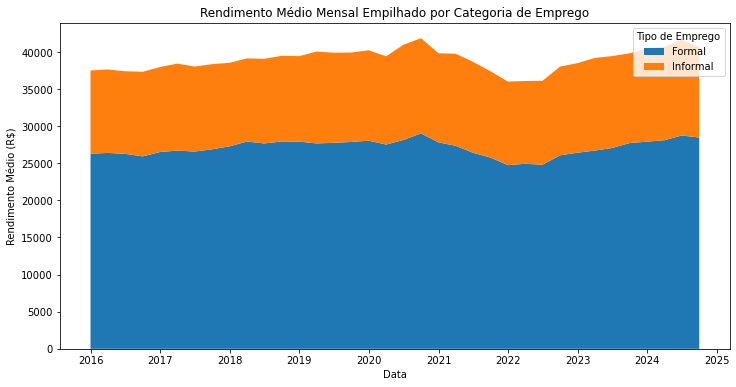

In [46]:
new_df = pd.DataFrame({
    'formal': df_rendimentos[tipo_trabalho['trabalho_formal']].sum(axis=1),
    'informal': df_rendimentos[tipo_trabalho['trabalho_informal']].sum(axis=1)
}, index=df_rendimentos.index)
new_df = new_df.loc["2015-12-31":]

# Plot do gráfico de área empilhada
plt.figure(figsize=(12, 6))
plt.stackplot(new_df.index, 
              new_df['formal'], 
              new_df['informal'], 
              labels=['Formal', 'Informal'])

# Configurações do gráfico
plt.title("Rendimento Médio Mensal Empilhado por Categoria de Emprego")
plt.xlabel("Data")
plt.ylabel("Rendimento Médio (R$)")
plt.legend(title="Tipo de Emprego")
plt.show()

In [47]:
# Tabela 4708 - Taxa de informalidade das pessoas de 14 anos ou mais de idade ocupadas na semana de referência
tabela_informalidade = sidrapy.get_table(table_code="4708",
                                        territorial_level="1",
                                        ibge_territorial_code="all",
                                        period="all",
                                        variable="12466") # Distribuição percentual das pessoas de 14 anos ou mais de idade ocupadas na semana de referência com rendimento
                                        
tabela_informalidade.head()

,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N
0,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Brasil (Código),Brasil,Ano (Código),Ano,Variável (Código),Variável
1,1,Brasil,2,%,39.1,1,Brasil,2016,2016,12466,Taxa de informalidade das pessoas de 14 anos o...
2,1,Brasil,2,%,40.6,1,Brasil,2017,2017,12466,Taxa de informalidade das pessoas de 14 anos o...
3,1,Brasil,2,%,40.9,1,Brasil,2018,2018,12466,Taxa de informalidade das pessoas de 14 anos o...
4,1,Brasil,2,%,40.9,1,Brasil,2019,2019,12466,Taxa de informalidade das pessoas de 14 anos o...


0           tx_informalidade
Ano                         
2017-01-01              40.6
2018-01-01              40.9
2019-01-01              40.9
2020-01-01              37.6
2021-01-01              39.5
2022-01-01              39.4
2023-01-01              39.2


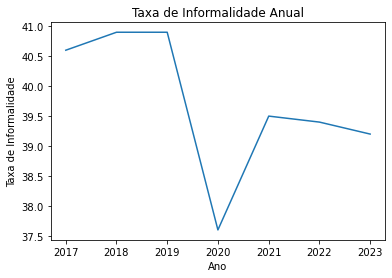

In [48]:
# Primeira coluna como cabeçalho
df_informalidade = tabela_informalidade
df_informalidade.columns = df_informalidade.iloc[0]
df_informalidade = df_informalidade[1:]

# Colunas de interesse
df_informalidade = df_informalidade.iloc[1:, [4, 8]]
df_informalidade['Valor'] = pd.to_numeric(df_informalidade['Valor'], errors='coerce')
df_informalidade['Ano'] = pd.to_datetime(df_informalidade['Ano'], format='%Y')

# Renomeia as colunas
df_informalidade.rename(columns={"Valor": "tx_informalidade"}, inplace=True)
df_informalidade.set_index("Ano", inplace=True)

print(df_informalidade.head(10))

# Visualização
plt.Figure(figsize=(12, 6))
plt.plot(df_informalidade.index, df_informalidade['tx_informalidade'])
plt.xlabel("Ano")
plt.ylabel("Taxa de Informalidade")
plt.title("Taxa de Informalidade Anual")
plt.show()

## 2. Nível de instrução e horas trabalhadas
### 2.1. Limpeza e coleta

In [49]:
# Tabela 7433 - Pessoas de 14 anos ou mais de idade ocupadas na semana de referência com rendimento, por nível de instrução
tabela_instrucao = sidrapy.get_table(table_code="7433",
                                        territorial_level="1",
                                        ibge_territorial_code="all",
                                        period="all",
                                        variable="10767", # Distribuição percentual das pessoas de 14 anos ou mais de idade ocupadas na semana de referência com rendimento
                                        classifications={"1568": "18837,11779,11628,11629,11630,11631,99713"})
tabela_instrucao.head()

,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N,D4C,D4N
0,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Brasil (Código),Brasil,Ano (Código),Ano,Variável (Código),Variável,Nível de instrução (Código),Nível de instrução
1,1,Brasil,2,%,3.3,1,Brasil,2012,2012,10767,Distribuição percentual das pessoas de 14 anos...,18837,Sem instrução
2,1,Brasil,2,%,28.5,1,Brasil,2012,2012,10767,Distribuição percentual das pessoas de 14 anos...,11779,Ensino fundamental incompleto ou equivalente
3,1,Brasil,2,%,10.8,1,Brasil,2012,2012,10767,Distribuição percentual das pessoas de 14 anos...,11628,Ensino fundamental completo ou equivalente
4,1,Brasil,2,%,6.6,1,Brasil,2012,2012,10767,Distribuição percentual das pessoas de 14 anos...,11629,Ensino médio incompleto ou equivalente


In [50]:
# Primeira coluna como cabeçalho
df_instrucao = tabela_instrucao
df_instrucao.columns = df_instrucao.iloc[0]
df_instrucao = df_instrucao[1:]

# Colunas de interesse
df_instrucao = df_instrucao.iloc[1:, [4, 8, 12]]
df_instrucao['Valor'] = pd.to_numeric(df_instrucao['Valor'], errors='coerce')
df_instrucao['Ano'] = pd.to_datetime(df_instrucao['Ano'], format='%Y')

# Renomeia as colunas
df_instrucao.rename(columns={"Nível de instrução": "nivel_instrucao",
                              "Valor": "valores"}, 
                              inplace=True)
df_instrucao = df_instrucao.pivot(index="Ano", columns="nivel_instrucao", values="valores")

df_instrucao.head(10)

nivel_instrucao,Ensino fundamental completo ou equivalente,Ensino fundamental incompleto ou equivalente,Ensino médio completo ou equivalente,Ensino médio incompleto ou equivalente,Ensino superior incompleto ou equivalente,Sem instrução,Superior completo
Ano,,,,,,,
2012-01-01,10.8,28.5,31.0,6.6,5.3,NaN,14.5
2013-01-01,10.9,27.6,31.5,6.5,5.3,3.1,15.1
2014-01-01,10.7,26.6,31.9,6.4,5.5,2.8,16.1
2015-01-01,10.3,25.5,32.1,6.5,5.7,2.8,17.0
2016-01-01,9.3,24.4,33.2,6.4,5.6,2.8,18.4
2017-01-01,8.8,24.1,33.4,6.8,5.8,2.4,18.6
2018-01-01,8.4,23.0,33.5,6.7,6.2,2.1,20.0
2019-01-01,8.1,21.9,34.3,6.8,6.4,2.0,20.5
2020-01-01,7.5,19.7,35.5,6.1,6.8,1.5,23.0


In [51]:
df_instrucao.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2012-01-01 to 2023-01-01
Data columns (total 7 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Ensino fundamental completo ou equivalente    12 non-null     float64
 1   Ensino fundamental incompleto ou equivalente  12 non-null     float64
 2   Ensino médio completo ou equivalente          12 non-null     float64
 3   Ensino médio incompleto ou equivalente        12 non-null     float64
 4   Ensino superior incompleto ou equivalente     12 non-null     float64
 5   Sem instrução                                 11 non-null     float64
 6   Superior completo                             12 non-null     float64
dtypes: float64(7)
memory usage: 768.0 bytes


### 2.2. Resultados
O primeiro gráfico mostra os aumentos nos dois maiores graus de instrução analisados pelo IBGE, o ensino médio e o ensino superior

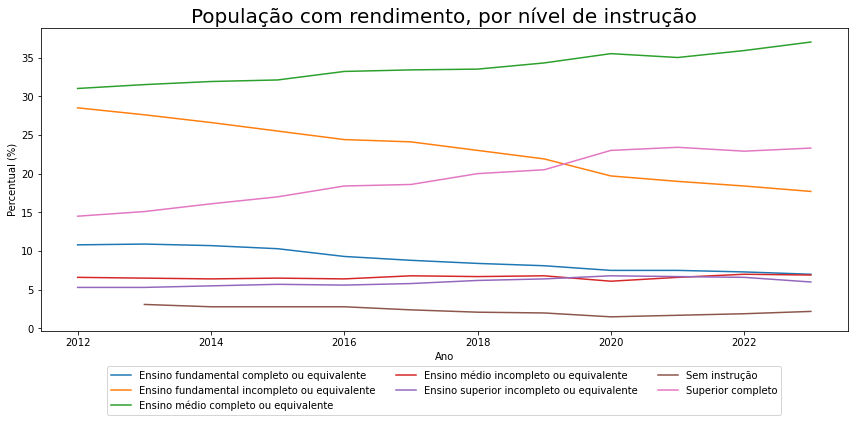

In [52]:
# Visualização
plt.figure(figsize=(12, 6))
for col in df_instrucao.columns:
    plt.plot(df_instrucao.index, df_instrucao[col], label=col)

# Configurações do gráfico
plt.xlabel("Ano")
plt.ylabel("Percentual (%)")
plt.title("População com rendimento, por nível de instrução", fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.grid(False)

plt.tight_layout()
plt.show()

In [53]:
# Tabela 6373 - Média de horas habitualmente trabalhadas por semana e efetivamente trabalhadas na semana de referência, 
# no trabalho principal e em todos os trabalhos, das pessoas de 14 anos ou mais de idade, por nível de instrução

tabela_horas_instrucao = sidrapy.get_table(table_code="6373",
    territorial_level="1",
    ibge_territorial_code="all",
    period="all",
    variable="8186", # Média de horas habitualmente trabalhadas por semana no trabalho principal
    classifications={"1568": "120706,11779,11628,11629,11630,11631,11632"})

tabela_horas_instrucao.head(10)

,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N,D4C,D4N
0,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Brasil (Código),Brasil,Trimestre (Código),Trimestre,Variável (Código),Variável,Nível de instrução (Código),Nível de instrução
1,1,Brasil,1574,Horas,38.1,1,Brasil,201201,1º trimestre 2012,8186,Média de horas habitualmente trabalhadas por s...,120706,Sem instrução e menos de 1 ano de estudo
2,1,Brasil,1574,Horas,40.6,1,Brasil,201201,1º trimestre 2012,8186,Média de horas habitualmente trabalhadas por s...,11779,Ensino fundamental incompleto ou equivalente
3,1,Brasil,1574,Horas,41.9,1,Brasil,201201,1º trimestre 2012,8186,Média de horas habitualmente trabalhadas por s...,11628,Ensino fundamental completo ou equivalente
4,1,Brasil,1574,Horas,40.4,1,Brasil,201201,1º trimestre 2012,8186,Média de horas habitualmente trabalhadas por s...,11629,Ensino médio incompleto ou equivalente
5,1,Brasil,1574,Horas,42.0,1,Brasil,201201,1º trimestre 2012,8186,Média de horas habitualmente trabalhadas por s...,11630,Ensino médio completo ou equivalente
6,1,Brasil,1574,Horas,38.3,1,Brasil,201201,1º trimestre 2012,8186,Média de horas habitualmente trabalhadas por s...,11631,Ensino superior incompleto ou equivalente
7,1,Brasil,1574,Horas,38.5,1,Brasil,201201,1º trimestre 2012,8186,Média de horas habitualmente trabalhadas por s...,11632,Ensino superior completo ou equivalente
8,1,Brasil,1574,Horas,37.6,1,Brasil,201202,2º trimestre 2012,8186,Média de horas habitualmente trabalhadas por s...,120706,Sem instrução e menos de 1 ano de estudo
9,1,Brasil,1574,Horas,40.0,1,Brasil,201202,2º trimestre 2012,8186,Média de horas habitualmente trabalhadas por s...,11779,Ensino fundamental incompleto ou equivalente


In [54]:
# Primeira coluna como cabeçalho
df_horas_inst = tabela_horas_instrucao
df_horas_inst.columns = df_horas_inst.iloc[0]
df_horas_inst = df_horas_inst[1:]

# Colunas de interesse
df_horas_inst = df_horas_inst.iloc[1:, [4, 7, 12]]
df_horas_inst['Valor'] = pd.to_numeric(df_horas_inst['Valor'], errors='coerce')
df_horas_inst["Trimestre (Código)"] = df_horas_inst["Trimestre (Código)"].apply(converter_trimestre)

# Renomeia as colunas
df_horas_inst.rename(columns={"Trimestre (Código)": "data",
                              "Nível de instrução": "instrucao",
                              "Valor": "valores"}, 
                              inplace=True)
df_horas_inst = df_horas_inst.pivot(index="data", columns="instrucao", values="valores")

df_horas_inst.head(10)

instrucao,Ensino fundamental completo ou equivalente,Ensino fundamental incompleto ou equivalente,Ensino médio completo ou equivalente,Ensino médio incompleto ou equivalente,Ensino superior completo ou equivalente,Ensino superior incompleto ou equivalente,Sem instrução e menos de 1 ano de estudo
data,,,,,,,
2012-01-31,41.9,40.6,42.0,40.4,38.5,38.3,NaN
2012-02-29,41.5,40.0,41.8,40.0,38.3,38.0,37.6
2012-03-31,41.3,39.9,41.8,39.5,38.3,37.9,37.6
2012-04-30,41.2,39.9,41.8,39.8,38.5,38.0,37.6
2013-01-31,41.0,39.8,41.8,39.8,38.4,38.1,37.7
2013-02-28,40.9,39.6,41.5,39.5,38.4,37.9,37.0
2013-03-31,41.1,39.8,41.6,39.5,38.5,38.0,37.3
2013-04-30,40.9,39.6,41.5,39.7,38.3,37.9,37.0
2014-01-31,41.1,39.6,41.5,39.6,38.5,38.1,36.5


In [55]:
df_horas_inst.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42 entries, 2012-01-31 to 2024-02-29
Data columns (total 7 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Ensino fundamental completo ou equivalente    42 non-null     float64
 1   Ensino fundamental incompleto ou equivalente  42 non-null     float64
 2   Ensino médio completo ou equivalente          42 non-null     float64
 3   Ensino médio incompleto ou equivalente        42 non-null     float64
 4   Ensino superior completo ou equivalente       42 non-null     float64
 5   Ensino superior incompleto ou equivalente     42 non-null     float64
 6   Sem instrução e menos de 1 ano de estudo      41 non-null     float64
dtypes: float64(7)
memory usage: 2.6 KB


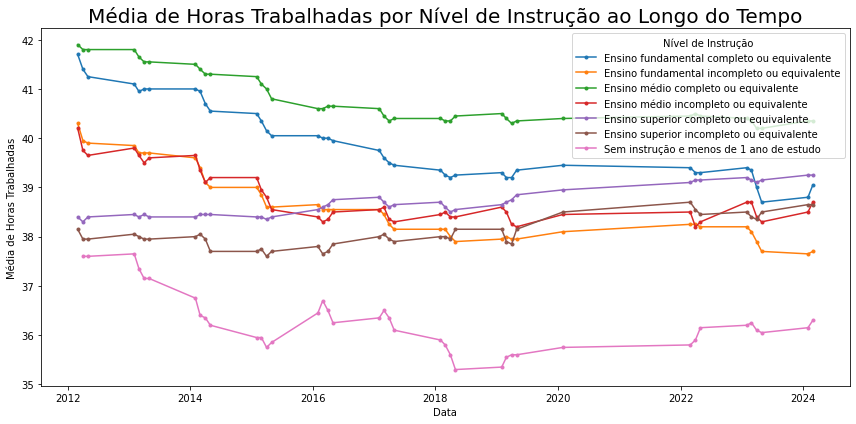

In [56]:
window_size = 2
df_horas_smooth = df_horas_inst.rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))

for nivel in df_horas_smooth.columns:
    plt.plot(df_horas_smooth.index, df_horas_smooth[nivel], label=nivel, marker=".")

plt.title("Média de Horas Trabalhadas por Nível de Instrução ao Longo do Tempo", fontsize=20)
plt.xlabel("Data")
plt.ylabel("Média de Horas Trabalhadas")
plt.legend(title="Nível de Instrução")
plt.grid(False)

plt.tight_layout()
plt.show()

In [57]:
# Correlação entre nível de instrução e horas trabalhadas
media_horas_por_instrucao = df_horas_inst.mean()

# Ordenando variáveis categóricas
nivel_instrucao_numerico = {
    'Sem instrução e menos de 1 ano de estudo': 0,
    'Ensino fundamental incompleto ou equivalente': 1,
    'Ensino fundamental completo ou equivalente': 2,
    'Ensino médio incompleto ou equivalente': 3,
    'Ensino médio completo ou equivalente': 4,
    'Ensino superior incompleto ou equivalente': 5,
    'Ensino superior completo ou equivalente': 6
}
nivel_instrucao_valores = [nivel_instrucao_numerico[nivel] for nivel in media_horas_por_instrucao.index]

correlacao, p_valor = pearsonr(nivel_instrucao_valores, media_horas_por_instrucao.values)

print(f"Coeficiente de correlação de Pearson: {correlacao}")
print(f"Valor p: {p_valor}")

Coeficiente de correlação de Pearson: 0.3792891055329582
Valor p: 0.4013973681050447


## 3. IDEB e qualidade de ensino
### 3.1. Coleta e limpeza

In [58]:
query = """
  SELECT
    dados.ano as ano,
    dados.rede as rede,
    dados.ensino as ensino,
    dados.anos_escolares as anos_escolares,
    dados.taxa_aprovacao as taxa_aprovacao,
    dados.indicador_rendimento as indicador_rendimento,
    dados.ideb as ideb
FROM `basedosdados.br_inep_ideb.brasil` AS dados
"""

ideb = bd.read_sql(query = query, billing_project_id = billing_id)
ideb.head(10)

Downloading: 100%|██████████| 140/140 [00:00<00:00, 323.15rows/s]


,ano,rede,ensino,anos_escolares,taxa_aprovacao,indicador_rendimento,ideb
0,2005,privada,medio,todos (1-4),92.7,0.933066,5.6
1,2005,estadual,medio,todos (1-4),70.5,0.747708,3.0
2,2005,total,medio,todos (1-4),73.2,0.771854,3.4
3,2005,publica,medio,todos (1-4),70.6,0.750616,3.1
4,2005,total,fundamental,finais (6-9),77.0,0.772003,3.5
5,2005,municipal,fundamental,finais (6-9),73.2,0.740564,3.1
6,2005,publica,fundamental,finais (6-9),75.0,0.753133,3.2
7,2005,privada,fundamental,finais (6-9),94.5,0.944993,5.8
8,2005,estadual,fundamental,finais (6-9),76.3,0.763635,3.3
9,2005,municipal,fundamental,iniciais (1-5),78.1,0.795953,3.4


In [59]:
ideb['ensino_anos'] = ideb['ensino'] + ' - ' + ideb['anos_escolares']
ideb.drop(columns=['ensino', 'anos_escolares'], inplace=True)

df_aprovacao = ideb[ideb['rede']=='total'].pivot(index='ano', columns='ensino_anos', values='taxa_aprovacao')
df_aprovacao.head()

ensino_anos,fundamental - finais (6-9),fundamental - iniciais (1-5),medio - todos (1-4)
ano,,,
2005,77.0,81.6,73.2
2007,79.8,85.8,74.1
2009,81.3,88.5,75.9
2011,83.4,91.2,77.4
2013,85.1,92.7,80.1


In [60]:
df_rendimento_escolar = ideb[ideb['rede']=='total'].pivot(index='ano', columns='ensino_anos', values='indicador_rendimento')
df_rendimento_escolar.head()

ensino_anos,fundamental - finais (6-9),fundamental - iniciais (1-5),medio - todos (1-4)
ano,,,
2005,0.772003,0.827901,0.771854
2007,0.799533,0.864096,0.778403
2009,0.815259,0.888155,0.795302
2011,0.834937,0.912809,0.802240
2013,0.852224,0.927872,0.823323
